In [1]:
"""
Augmentation and pre-processing pipeline in Pytorch.
Author: Booy Faassen
"""

import nvsmi
import os
import pathlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import shutil
import math

if torch.cuda.is_available():
    print('We have a GPU!')
else:
    print('Sorry, CPU only.')
from torchvision import transforms, datasets, models
import torchvision.utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from typing import Tuple, Dict, List

Sorry, CPU only.


In [2]:
"""
Different augmentation or preprocessing techniques:
1. Strong augmentation
2. Weak augmentation
3. Preprocessing without augmentation
"""

image_transforms = {
    'strong': transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-5,5), expand=False, fill=0),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1)),
        transforms.RandomAffine(degrees=0, shear=(-5, 5), fill=0), # shear
        transforms.GaussianBlur(kernel_size=13, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ]),
    'weak': transforms.Compose([
        transforms.Resize(size=256),
        transforms.GaussianBlur(kernel_size=13, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ]),
    'preprocess': transforms.Compose([
        transforms.Resize(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ])
}

In [3]:
""" Finds the class folder names in a target directory. """

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Assumes target directory is in standard image classification format.
    Args:
        directory (str): target directory to load classnames from.
    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    Example:
        find_classes("data/train")
        >>> (["0.0", "1.0"], {"0.0": 0, "1.0": 1})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [4]:
"""
Custom ImageFolder function
Source: https://www.learnpytorch.io/04_pytorch_custom_datasets/#4-option-1-loading-image-data-using-imagefolder
Partially copied from source but I added the functionality for different augmentations on different classes
"""

# Write a custom dataset class (inherits from torch.utils.data.Dataset)

class ImageFolderCustom(Dataset):
    
    def __init__(self, target_dir: str, transform_class0=None, transform_class1=None) -> None:
        self.paths = list(pathlib.Path(target_dir).glob("*/*.png"))
        self.transform_class0 = transform_class0
        self.transform_class1 = transform_class1
        self.classes, self.class_to_idx = find_classes(target_dir)
    
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB') # convert images to RGB
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (x, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if class_idx==0 and self.transform_class0:
            return self.transform_class0(img), class_idx # return data, label (x, y)
        elif class_idx==1 and self.transform_class1:
            return self.transform_class1(img), class_idx # return data, label (x, y)
        else:
            return img, class_idx # return data, label (x, y)

In [5]:
"""
Function that enables using different pre-established augmentation options:
1. Strong augmentation for all classes
2. Strong augmentation only for class 0.0 and pre-processing for 1.0
3. Strong augmentation only for class 1.0 and pre-processing for 0.0
4. Only pre-processing on all classes
"""

def augmentation(train_dir, test_dir, option: int = 1):
    """ Checking for valid input """
    valid_input = [1, 2, 3, 4]
    if option not in valid_input:
        raise ValueError("Option must be set to a value 1-4 (1 default, being augmentation for all training classes)")
    
    """ Function logic """
    if option==1:
        c0 = 'strong'
        c1 = 'strong'
    elif option==2:
        c0 = 'strong'
        c1 = 'preprocess'
    elif option==3:
        c0 = 'preprocess'
        c1 = 'strong'
    elif option==4:
        c0 = 'preprocess'
        c1 = 'preprocess'
    
    data = {
    'train': ImageFolderCustom(target_dir=train_dir,
                               transform_class0=image_transforms[c0],
                               transform_class1=image_transforms[c1]),
    'test': ImageFolderCustom(target_dir=test_dir,
                               transform_class0=image_transforms[c0],
                               transform_class1=image_transforms[c1])
    }
    
    return data

In [6]:
"""
Plot samples from the ImageFolderCustom
Source: https://www.learnpytorch.io/04_pytorch_custom_datasets/#52-create-a-custom-dataset-to-replicate-imagefolder
NOTE: this is directly copied from the source apart from variable names.
"""

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: List[str] = None,
                         n: int = 4,
                         display_shape: bool = True,
                         seed: int = None):
    if n > 4:
        n = 4
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 4, setting to 4 and removing shape display.")
        
    if seed:
        random.seed(seed)
    
    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # Setup plot
    plt.figure(figsize = (16, 8))
    
    # Loop through samples and display random samples
    for i, target_sample in enumerate(random_samples_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        
        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        target_image_adjust = target_image.permute(1, 2, 0)
        
        # Plot samples
        plt.subplot(1, n, i+1)
        plt.imshow(target_image_adjust)
        plt.axis('off')
        if classes:
            title = f"class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {target_image_adjust.shape}"
        plt.title(title)

In [7]:
"""
Alternative to using the augmentation function, data is initialized manually with:
"""

"""
train_dir = './data/Augmented/dataset01_aug/train' # should be changed to e.g. './dataset01/train'
test_dir = './data/Augmented/dataset01_aug/test' # should be changed to e.g. './dataset01/test'

data = {
    'train': ImageFolderCustom(target_dir=train_dir,
                               transform_class0=image_transforms['strong'], # Adjust transformation to augment class 0
                               transform_class1=image_transforms['strong']), # Adjust transformation to augment class 1
    'test': ImageFolderCustom(target_dir=test_dir,
                               transform_class0=image_transforms['preprocess'],
                               transform_class1=image_transforms['preprocess'])
}
"""

"\ntrain_dir = './data/Augmented/dataset01_aug/train' # should be changed to e.g. './dataset01/train'\ntest_dir = './data/Augmented/dataset01_aug/test' # should be changed to e.g. './dataset01/test'\n\ndata = {\n    'train': ImageFolderCustom(target_dir=train_dir,\n                               transform_class0=image_transforms['strong'], # Adjust transformation to augment class 0\n                               transform_class1=image_transforms['strong']), # Adjust transformation to augment class 1\n    'test': ImageFolderCustom(target_dir=test_dir,\n                               transform_class0=image_transforms['preprocess'],\n                               transform_class1=image_transforms['preprocess'])\n}\n"

In [52]:
""" Load the data """

train_dir = './data/dataset01/train' # should be changed to e.g. './dataset01/train'
test_dir = './data/dataset01/test' # should be changed to e.g. './dataset01/test'

data = augmentation(train_dir, test_dir, option=1) # options range from 1-4

bs = 32 # batch size
num_classes = len(data['train'].classes) # 2

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data = len(data['train']) # check if this is really needed
test_data = len(data['test']) # check if this is really needed
# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)
# Print the train, validation and test set data sizes
print('train:', train_data, 'test:', test_data, 'total:', train_data + test_data)

print(len(train_data_loader)) # based on the length of the sampler. It returns an estimate based on len(dataset) / batch_size
print(len(test_data_loader))

# print(torch.utils.data.get_worker_info()) # should return info on the current data loader.

train: 1969 test: 655 total: 2624
62
21


In [11]:
print(len(data['train']))
print(data['train'].classes)
print(data['train'].class_to_idx)

2658
['0.0', '1.0']
{'0.0': 0, '1.0': 1}


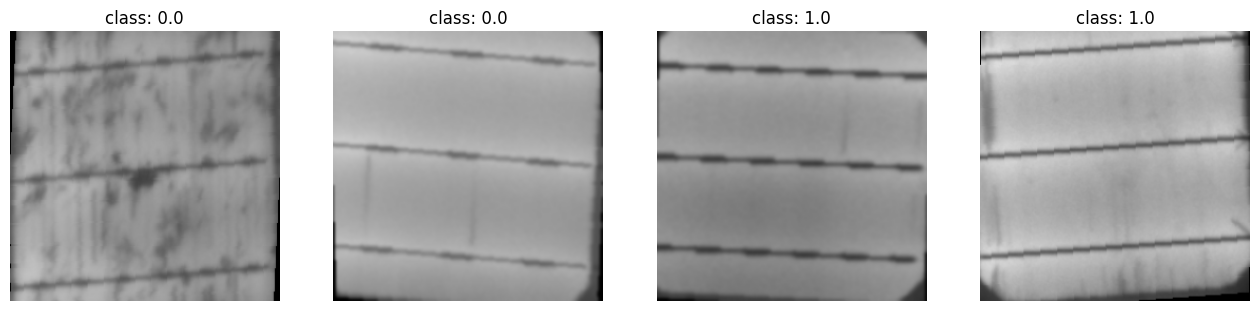

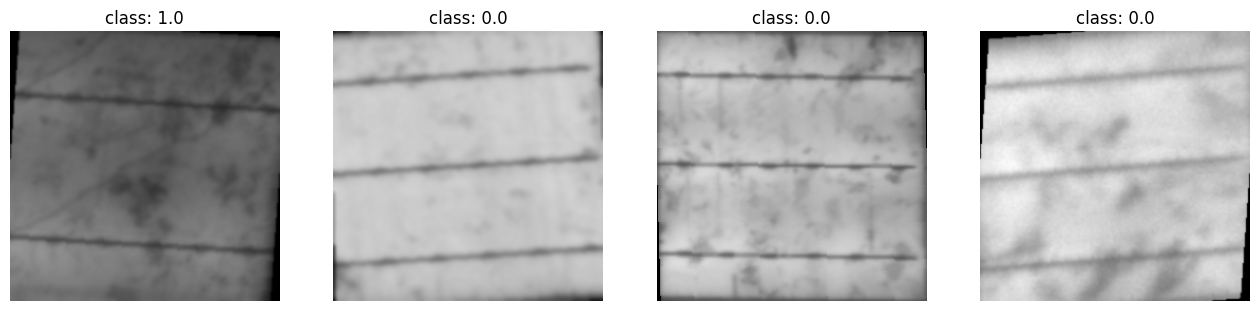

In [53]:
""" Displaying a few random samples """

display_random_images(data['train'], n=4, classes=data['train'].classes, seed=None, display_shape=False)
display_random_images(data['test'], n=4, classes=data['test'].classes, seed=None, display_shape=False)

In [13]:
""" Save augmented images """

def save_aug_images(ds_path = 'data/Aug_dataset01/train', data_loader = train_data_loader, num_batches = 1):
    path_00 = ds_path + '/0.0'
    path_10 = ds_path + '/1.0'

    #Calculate how many times we must loop over all images in the data_loader:
    loops = math.ceil(num_batches / len(data_loader))
    
    num_iter = 0
    num_loops = 0
    for loop in range(loops):
        num_loops += 1
        for batch_idx, (X, y) in enumerate(data_loader):
            num_iter += 1
            for i in range(len(X)):
                if y[i].numpy() == 1:
                    path = path_10
                #else:
                 #   path = path_00

                    name = path + "/image" + str(num_loops) + "_" + str(batch_idx) + '_' + str(i) + ".png"
                    torchvision.utils.save_image(X[i], name, "png")
            if num_iter == num_batches:
                break

In [14]:
""" calling save_aug_images """

# commented out for safety
#save_aug_images(ds_path = 'data/Augmented/dataset01_aug/test', data_loader = test_data_loader, num_batches = 46)

' calling save_aug_images '

In [15]:
""" Count number of images in a folder """

num_images_1 = len(os.listdir('data/Augmented/dataset01_aug/test/0.0/'))
print(num_images_1)

num_images_0 = len(os.listdir('data/Augmented/dataset01_aug/test/1.0/'))
print(num_images_0)

print(num_images_0 + num_images_1)

450
831
1281


In [16]:
""" remove images in folders """

path0 = 'data/Augmented/dataset01_aug/train/0.0/'
path1 = 'data/Augmented/dataset01_aug/train/1.0/'

# shutil.rmtree(path0) #commented out for safety
# shutil.rmtree(path1) #commented out for safety

# os.mkdir(path0)
# os.mkdir(path1)

In [17]:
"""
Replace the images with label 0.0 in the augmented folder with the images from the non-augmentation
"""

path0 = 'data/Augmented/dataset03_aug/train/0.0/'
shutil.rmtree(path0)
os.mkdir(path0)

src = 'data/dataset03/train/0.0'
dst = 'data/Augmetned/dataset03_aug/train/0.0'

shutil.copyfile(src, dst)

"\nCOMMENTED OUT FOR SATEFY\n\n\npath0 = 'data/Augmented/dataset03_aug/train/0.0/'\nshutil.rmtree(path0)\nos.mkdir(path0)\n\nsrc = 'data/dataset03/train/0.0'\ndst = 'data/Augmetned/dataset03_aug/train/0.0'\n\nshutil.copyfile(src, dst)\n"

In [30]:
"""
The below sections are to augment all of the majority-labelled images once.
"""

train_dir = './data/dataset02/train' # should be changed to e.g. './dataset01/train'
test_dir = './data/dataset02/test' # should be changed to e.g. './dataset01/test'

data = augmentation(train_dir, test_dir, option=1) # options range from 1-4

label_0 = len(os.listdir(train_dir + "/0.0"))
label_1 = len(os.listdir(train_dir + "/1.0"))
bs = label_0 + label_1

print("count of 0 labels:", label_0)
print("count of 1 labels:", label_1)
print("count of all train labels:", bs)

num_classes = len(data['train'].classes) # 2

train_data = len(data['train'])
test_data = len(data['test'])
# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)
# Print the train, validation and test set data sizes
print('train:', train_data, 'test:', test_data, 'total:', train_data + test_data)

print(len(train_data_loader)) # based on the length of the sampler. It returns an estimate based on len(dataset) / batch_size
print(len(test_data_loader))

# print(torch.utils.data.get_worker_info()) # should return info on the current data loader.

count of 0 labels: 538
count of 1 labels: 268
count of all train labels: 806
train: 806 test: 268 total: 1074
1
1


In [10]:
""" Save augmented images only for the majority class: 0.0"""

def save_aug_images_2(ds_path = 'data/Augmented/ds01_aug/train', data_loader = train_data_loader, num_batches = 1, label='0.0'):
    #legal values for label variable:
    label_vals = {'0.0': 0, '1.0': 1}
    if label not in label_vals:
        raise ValueError("label must be a string of either '0.0' or '1.0'.")
        
    #Calculate how many times we must loop over all images in the data_loader:
    loops = math.ceil(num_batches / len(data_loader)) # should give 1.
    
    num_iter = 0
    num_loops = 0
    for loop in range(loops):
        num_loops += 1
        for batch_idx, (X, y) in enumerate(data_loader):
            num_iter += 1
            for i in range(len(X)):
                if y[i].numpy() == label_vals[label]:
                    name = ds_path + "/image" + str(num_loops) + "_" + str(batch_idx) + '_' + str(i) + ".png"
                    torchvision.utils.save_image(X[i], name, "png")
            if num_iter == num_batches:
                break

In [31]:
""" Create a temporary file """

def make_temp_file(path, label = '0.0'):
    name = label + '_temp'
    path = os.path.join(path, name)
    if os.path.exists(path):
        return path
    else:
        os.mkdir(path)
        return path

In [12]:
""" Check that the number of images are the same in the new file as in the old file. """

def check_success(from_path, to_path):
    if len(os.listdir(from_path)) == len(os.listdir(to_path)):
        print("Success!")
    else:
        raise ValueError("The number of images has changed. This is not good.")

In [13]:
""" Replace folders """

def replace_folders(org_path, temp_path):
    shutil.rmtree(org_path)
    os.rename(temp_path, org_path)

In [32]:
""" Augment the majority label ('0.0') and replace it with the unaugmented images in the specified folder. """

# Commented out for safety.

#path = make_temp_file(path = './data/dataset02/train', label = '0.0')
#print(path)
#save_aug_images_2(ds_path = path, data_loader = train_data_loader, num_batches = 1, label='0.0')

#check_success(from_path = train_dir+'/0.0', to_path = path)

#replace_folders(org_path = './data/augmented/dataset06_aug/train/0.0', temp_path = './data/augmented/dataset06_aug/train/0.0_temp')

#check_success(from_path = train_dir+'/0.0', to_path = './data/augmented/dataset06_aug/train/0.0')

./data/dataset02/train\0.0_temp
Success!
